In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
import sys, platform, torch, torchvision
from torch.utils.data import DataLoader
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

batch_size = 32
train = torchvision.datasets.CIFAR10(root='./data', train=True,  download=True, transform=transform)
test  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

use_workers = 0 if ("ipykernel" in sys.modules or platform.system()=="Windows") else 2

100%|██████████| 170M/170M [00:05<00:00, 28.4MB/s]


In [3]:
trainLoader = DataLoader(train, batch_size=batch_size, shuffle=True,
                         num_workers=use_workers, pin_memory=True)
testLoader  = DataLoader(test,  batch_size=batch_size, shuffle=False,
                         num_workers=use_workers, pin_memory=True)

In [4]:
print("Классы:", train.classes)
print("Количество классов:", len(train.classes))

Классы: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Количество классов: 10


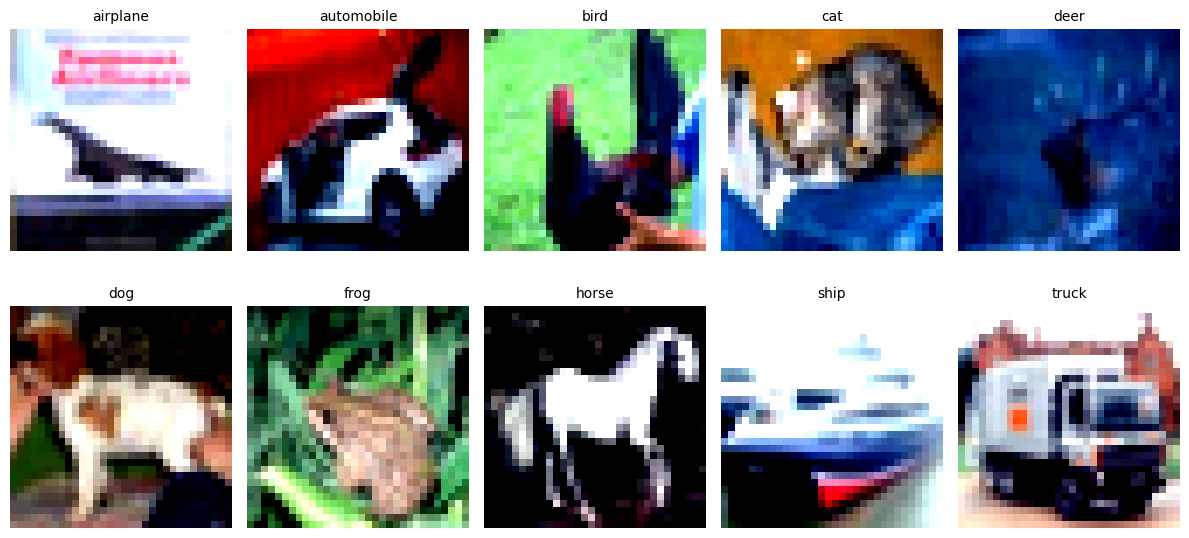

In [5]:
# выведу по одному изображения каждого класса

selected_images = {}
selected_labels = {}

for img, label in test:
    if label not in selected_images:
        selected_images[label] = img
        selected_labels[label] = label
    if len(selected_images) == 10:
        break

plt.figure(figsize=(12, 6))

for i in range(10):
    plt.subplot(2, 5, i + 1)
    img = selected_images[i]
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(train.classes[i], fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm

class CNN(nn.Module):
    def __init__(self, num_classes=10, dropout=0.25):
        super().__init__()
        def block(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
            )
        self.stage1 = block(3, 64)
        self.stage2 = block(64, 128)
        self.stage3 = block(128, 256)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(dropout)
        self.head = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1),
        )
        self.fc = nn.Linear(128, num_classes)
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.stage1(x); x = self.pool(x); x = self.dropout(x)
        x = self.stage2(x); x = self.pool(x); x = self.dropout(x)
        x = self.stage3(x); x = self.pool(x); x = self.dropout(x)
        x = self.head(x)
        x = x.flatten(1)
        x = self.fc(x)
        return x



In [7]:
import torch
import torch.nn as nn
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import os

def train_model(
    model,
    train_loader,
    test_loader,
    criterion,
    optimizer,
    scheduler=None,
    num_epochs=35,
    device=None,
    step_on="val",
    plot_curves=True,
    plot_accuracy=True,
    save_dir=None,
    early_stop_acc=95.0,
    save_checkpoint_path=None
):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    print(f"Using {'GPU ' + torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

    def get_lr(optim):
        for pg in optim.param_groups:
            return pg.get("lr", None)

    history = {
        "train_losses": [],
        "train_accuracies": [],
        "test_losses": [],
        "test_accuracies": [],
        "best_test_acc": 0.0,
    }
    best_state = None
    stopped_early = False

    for epoch in range(num_epochs):
        model.train()
        train_loss_sum, train_batches = 0.0, 0
        train_correct, train_total = 0, 0

        for xb, yb in tqdm(train_loader, desc=f"Train {epoch+1}/{num_epochs}", leave=False):
            xb, yb = xb.to(device), yb.to(device)

            optimizer.zero_grad(set_to_none=True)
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

            train_loss_sum += loss.item()
            train_batches += 1
            preds = logits.argmax(1)
            train_total += yb.size(0)
            train_correct += (preds == yb).sum().item()

        train_loss = train_loss_sum / max(1, train_batches)
        train_acc  = 100.0 * train_correct / max(1, train_total)
        history["train_losses"].append(train_loss)
        history["train_accuracies"].append(train_acc)

        model.eval()
        test_loss_sum, test_batches = 0.0, 0
        test_correct, test_total = 0, 0
        with torch.no_grad():
            for xb, yb in tqdm(test_loader, desc=f"Test  {epoch+1}/{num_epochs}", leave=False):
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)
                vloss = criterion(logits, yb)

                test_loss_sum += vloss.item()
                test_batches += 1

                preds = logits.argmax(1)
                test_total += yb.size(0)
                test_correct += (preds == yb).sum().item()

        test_loss = test_loss_sum / max(1, test_batches)
        test_acc  = 100.0 * test_correct / max(1, test_total)
        history["test_losses"].append(test_loss)
        history["test_accuracies"].append(test_acc)

        if scheduler is not None:
            try:
                metric = test_loss if step_on == "val" else train_loss
                scheduler.step(metric)
            except TypeError:
                scheduler.step()

        lr_now = get_lr(optimizer)
        print(
            f"Epoch [{epoch+1}/{num_epochs}] | "
            f"train_loss: {train_loss:.4f} | train_acc: {train_acc:.2f}% | "
            f"test_loss: {test_loss:.4f} | test_acc: {test_acc:.2f}% | "
            f"lr: {lr_now:.2e}"
        )

        if test_acc > history["best_test_acc"]:
            history["best_test_acc"] = test_acc
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            if save_checkpoint_path:
                torch.save(best_state, save_checkpoint_path)

        if test_acc >= early_stop_acc:
            # если точность больши или равна 95%
            print(f"Early stop: test accuracy {test_acc:.2f}% ≥ {early_stop_acc:.2f}%.")
            stopped_early = True
            break

    if best_state is not None:
        model.load_state_dict(best_state)

    if plot_curves:
        epochs = range(1, len(history["train_losses"]) + 1)

        plt.figure()
        plt.plot(epochs, history["train_losses"], label="train loss")
        plt.plot(epochs, history["test_losses"], label="test loss")
        plt.xlabel("epoch"); plt.ylabel("loss"); plt.title("Loss vs. epoch")
        plt.grid(True, linestyle="--", alpha=0.5); plt.legend()
        if save_dir:
            os.makedirs(save_dir, exist_ok=True)
            plt.savefig(os.path.join(save_dir, "loss_curve.png"), dpi=150, bbox_inches="tight")
        plt.show()

        if plot_accuracy:
            plt.figure()
            plt.plot(epochs, history["train_accuracies"], label="train acc (%)")
            plt.plot(epochs, history["test_accuracies"], label="test acc (%)")
            plt.xlabel("epoch"); plt.ylabel("accuracy (%)"); plt.title("Accuracy vs. epoch")
            plt.grid(True, linestyle="--", alpha=0.5); plt.legend()
            if save_dir:
                os.makedirs(save_dir, exist_ok=True)
                plt.savefig(os.path.join(save_dir, "accuracy_curve.png"), dpi=150, bbox_inches="tight")
            plt.show()

    if stopped_early:
        print(f"Best test acc: {history['best_test_acc']:.2f}% (model restored to best).")

    return model, history


Using GPU Tesla T4


Train 1/35:   0%|          | 0/1563 [00:00<?, ?it/s]

Test  1/35:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch [1/35] | train_loss: 1.4190 | train_acc: 53.35% | test_loss: 1.1563 | test_acc: 65.06% | lr: 3.00e-04


Train 2/35:   0%|          | 0/1563 [00:00<?, ?it/s]

Test  2/35:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch [2/35] | train_loss: 1.0894 | train_acc: 67.93% | test_loss: 0.9994 | test_acc: 71.54% | lr: 3.00e-04


Train 3/35:   0%|          | 0/1563 [00:00<?, ?it/s]

Test  3/35:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch [3/35] | train_loss: 0.9500 | train_acc: 74.14% | test_loss: 0.9016 | test_acc: 75.92% | lr: 3.00e-04


Train 4/35:   0%|          | 0/1563 [00:00<?, ?it/s]

Test  4/35:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch [4/35] | train_loss: 0.8642 | train_acc: 77.79% | test_loss: 0.8309 | test_acc: 79.33% | lr: 3.00e-04


Train 5/35:   0%|          | 0/1563 [00:00<?, ?it/s]

Test  5/35:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch [5/35] | train_loss: 0.7988 | train_acc: 80.69% | test_loss: 0.7856 | test_acc: 81.60% | lr: 3.00e-04


Train 6/35:   0%|          | 0/1563 [00:00<?, ?it/s]

Test  6/35:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch [6/35] | train_loss: 0.7527 | train_acc: 82.54% | test_loss: 0.7524 | test_acc: 82.97% | lr: 3.00e-04


Train 7/35:   0%|          | 0/1563 [00:00<?, ?it/s]

Test  7/35:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch [7/35] | train_loss: 0.7178 | train_acc: 84.16% | test_loss: 0.7192 | test_acc: 84.32% | lr: 3.00e-04


Train 8/35:   0%|          | 0/1563 [00:00<?, ?it/s]

Test  8/35:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch [8/35] | train_loss: 0.6840 | train_acc: 85.63% | test_loss: 0.6917 | test_acc: 85.24% | lr: 3.00e-04


Train 9/35:   0%|          | 0/1563 [00:00<?, ?it/s]

Test  9/35:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch [9/35] | train_loss: 0.6545 | train_acc: 87.03% | test_loss: 0.6663 | test_acc: 86.30% | lr: 3.00e-04


Train 10/35:   0%|          | 0/1563 [00:00<?, ?it/s]

Test  10/35:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch [10/35] | train_loss: 0.6309 | train_acc: 87.84% | test_loss: 0.6884 | test_acc: 85.49% | lr: 3.00e-04


Train 11/35:   0%|          | 0/1563 [00:00<?, ?it/s]

Test  11/35:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch [11/35] | train_loss: 0.6088 | train_acc: 88.85% | test_loss: 0.6675 | test_acc: 86.75% | lr: 3.00e-04


Train 12/35:   0%|          | 0/1563 [00:00<?, ?it/s]

Test  12/35:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch [12/35] | train_loss: 0.5868 | train_acc: 89.75% | test_loss: 0.6684 | test_acc: 86.70% | lr: 3.00e-04


Train 13/35:   0%|          | 0/1563 [00:00<?, ?it/s]

Test  13/35:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch [13/35] | train_loss: 0.5681 | train_acc: 90.65% | test_loss: 0.6404 | test_acc: 87.53% | lr: 3.00e-04


Train 14/35:   0%|          | 0/1563 [00:00<?, ?it/s]

Test  14/35:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch [14/35] | train_loss: 0.5506 | train_acc: 91.43% | test_loss: 0.6492 | test_acc: 87.32% | lr: 3.00e-04


Train 15/35:   0%|          | 0/1563 [00:00<?, ?it/s]

Test  15/35:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch [15/35] | train_loss: 0.5339 | train_acc: 92.12% | test_loss: 0.6438 | test_acc: 88.01% | lr: 3.00e-04


Train 16/35:   0%|          | 0/1563 [00:00<?, ?it/s]

Test  16/35:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch [16/35] | train_loss: 0.5204 | train_acc: 92.80% | test_loss: 0.6228 | test_acc: 88.81% | lr: 3.00e-04


Train 17/35:   0%|          | 0/1563 [00:00<?, ?it/s]

Test  17/35:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch [17/35] | train_loss: 0.5077 | train_acc: 93.30% | test_loss: 0.6355 | test_acc: 88.27% | lr: 3.00e-04


Train 18/35:   0%|          | 0/1563 [00:00<?, ?it/s]

Test  18/35:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch [18/35] | train_loss: 0.4938 | train_acc: 93.85% | test_loss: 0.6391 | test_acc: 87.89% | lr: 3.00e-04


Train 19/35:   0%|          | 0/1563 [00:00<?, ?it/s]

Test  19/35:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch [19/35] | train_loss: 0.4823 | train_acc: 94.43% | test_loss: 0.6405 | test_acc: 87.98% | lr: 3.00e-04


Train 20/35:   0%|          | 0/1563 [00:00<?, ?it/s]

Test  20/35:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch [20/35] | train_loss: 0.4718 | train_acc: 94.94% | test_loss: 0.6487 | test_acc: 87.54% | lr: 3.00e-04


Train 21/35:   0%|          | 0/1563 [00:00<?, ?it/s]

Test  21/35:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch [21/35] | train_loss: 0.4605 | train_acc: 95.37% | test_loss: 0.6209 | test_acc: 88.74% | lr: 3.00e-04


Train 22/35:   0%|          | 0/1563 [00:00<?, ?it/s]

Test  22/35:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch [22/35] | train_loss: 0.4537 | train_acc: 95.61% | test_loss: 0.6350 | test_acc: 88.20% | lr: 3.00e-04


Train 23/35:   0%|          | 0/1563 [00:00<?, ?it/s]

Test  23/35:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch [23/35] | train_loss: 0.4447 | train_acc: 96.01% | test_loss: 0.6188 | test_acc: 88.77% | lr: 3.00e-04


Train 24/35:   0%|          | 0/1563 [00:00<?, ?it/s]

Test  24/35:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch [24/35] | train_loss: 0.4376 | train_acc: 96.32% | test_loss: 0.6160 | test_acc: 88.90% | lr: 3.00e-04


Train 25/35:   0%|          | 0/1563 [00:00<?, ?it/s]

Test  25/35:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch [25/35] | train_loss: 0.4337 | train_acc: 96.59% | test_loss: 0.6143 | test_acc: 88.97% | lr: 3.00e-04


Train 26/35:   0%|          | 0/1563 [00:00<?, ?it/s]

Test  26/35:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch [26/35] | train_loss: 0.4245 | train_acc: 96.97% | test_loss: 0.6232 | test_acc: 88.76% | lr: 3.00e-04


Train 27/35:   0%|          | 0/1563 [00:00<?, ?it/s]

Test  27/35:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch [27/35] | train_loss: 0.4209 | train_acc: 97.08% | test_loss: 0.6126 | test_acc: 89.20% | lr: 3.00e-04


Train 28/35:   0%|          | 0/1563 [00:00<?, ?it/s]

Test  28/35:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch [28/35] | train_loss: 0.4145 | train_acc: 97.36% | test_loss: 0.6096 | test_acc: 89.42% | lr: 3.00e-04


Train 29/35:   0%|          | 0/1563 [00:00<?, ?it/s]

Test  29/35:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch [29/35] | train_loss: 0.4113 | train_acc: 97.38% | test_loss: 0.6097 | test_acc: 89.28% | lr: 3.00e-04


Train 30/35:   0%|          | 0/1563 [00:00<?, ?it/s]

Test  30/35:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch [30/35] | train_loss: 0.4042 | train_acc: 97.69% | test_loss: 0.6089 | test_acc: 89.08% | lr: 3.00e-04


Train 31/35:   0%|          | 0/1563 [00:00<?, ?it/s]

Test  31/35:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch [31/35] | train_loss: 0.4016 | train_acc: 97.84% | test_loss: 0.6205 | test_acc: 88.72% | lr: 3.00e-04


Train 32/35:   0%|          | 0/1563 [00:00<?, ?it/s]

Test  32/35:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch [32/35] | train_loss: 0.3949 | train_acc: 98.07% | test_loss: 0.6092 | test_acc: 89.22% | lr: 3.00e-04


Train 33/35:   0%|          | 0/1563 [00:00<?, ?it/s]

Test  33/35:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch [33/35] | train_loss: 0.3931 | train_acc: 98.11% | test_loss: 0.6081 | test_acc: 89.13% | lr: 3.00e-04


Train 34/35:   0%|          | 0/1563 [00:00<?, ?it/s]

Test  34/35:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch [34/35] | train_loss: 0.3904 | train_acc: 98.25% | test_loss: 0.6080 | test_acc: 88.79% | lr: 3.00e-04


Train 35/35:   0%|          | 0/1563 [00:00<?, ?it/s]

Test  35/35:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch [35/35] | train_loss: 0.3872 | train_acc: 98.35% | test_loss: 0.6015 | test_acc: 89.60% | lr: 3.00e-04


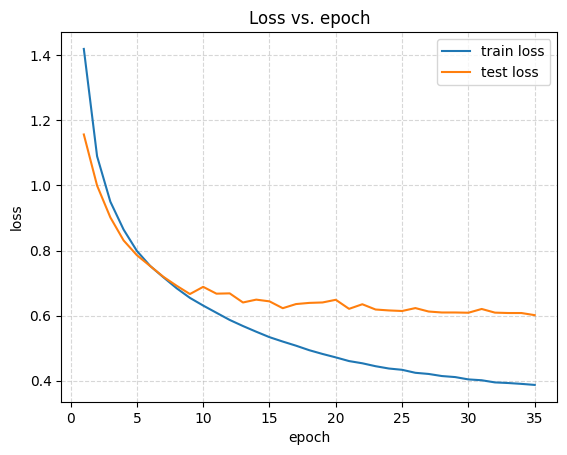

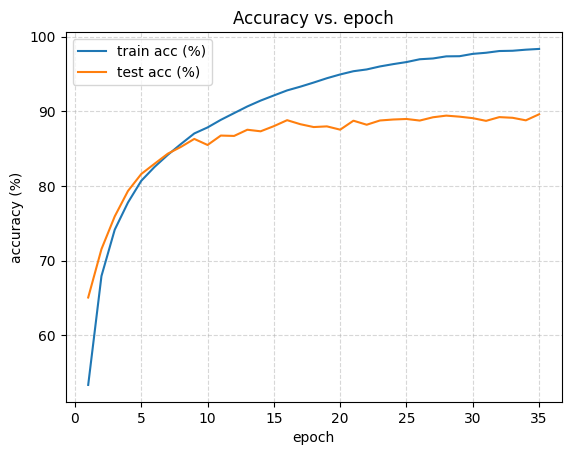

In [8]:
model = CNN()
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=4)

try:
    model, history = train_model(
        model,
        train_loader=trainLoader,
        test_loader=testLoader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        num_epochs=35,
        step_on="val"
    )
except KeyboardInterrupt:
    print("Прервали обучение, сохраняем уже обученную на данный момент модель")
    torch.save(model.state_dict(), "my_model.pth")

In [9]:

import random

CIFAR10_CLASSES = (
    "airplane","automobile","bird","cat","deer",
    "dog","frog","horse","ship","truck"
)


def evaluate_model(model, test_loader, criterion, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device).eval()

    test_loss_sum, test_batches = 0.0, 0
    correct, total = 0, 0
    all_preds, all_targets = [], []

    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)

            test_loss_sum += loss.item()
            test_batches += 1

            pred = logits.argmax(1)
            total += yb.size(0)
            correct += (pred == yb).sum().item()

            all_preds.append(pred.cpu())
            all_targets.append(yb.cpu())

    test_loss = test_loss_sum / max(1, test_batches)
    test_acc  = 100.0 * correct / max(1, total)
    print(f"[TEST] loss: {test_loss:.4f} | acc: {test_acc:.2f}%")

    try:
        from sklearn.metrics import classification_report, confusion_matrix
        y_true = torch.cat(all_targets).numpy()
        y_pred = torch.cat(all_preds).numpy()
        print("\nClassification report:")
        print(classification_report(y_true, y_pred, target_names=CIFAR10_CLASSES))

        cm = confusion_matrix(y_true, y_pred)

        plt.figure(figsize=(6, 6))
        plt.imshow(cm, interpolation="nearest")
        plt.title("Confusion matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.colorbar()
        plt.tight_layout()
        plt.show()
    except Exception:
        pass

    return {"test_loss": test_loss, "test_acc": test_acc}


def denormalize(img, mean=(0.4914,0.4822,0.4465), std=(0.2470,0.2435,0.2616)):
    if isinstance(mean, (list, tuple)):
        mean = torch.tensor(mean)[:, None, None]
    if isinstance(std, (list, tuple)):
        std = torch.tensor(std)[:, None, None]
    x = img.cpu()*std + mean
    x = x.clamp(0,1)
    return x.permute(1,2,0).numpy()

def show_predictions(model, dataset_or_loader, device=None, n=10,
                     mean=(0.4914,0.4822,0.4465),
                     std=(0.2470,0.2435,0.2616),
                     class_names=CIFAR10_CLASSES):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device).eval()

    if hasattr(dataset_or_loader, "dataset"):
        ds = dataset_or_loader.dataset
    else:
        ds = dataset_or_loader

    idxs = random.sample(range(len(ds)), k=n)

    plt.figure(figsize=(14, 6))
    with torch.no_grad():
        for i, idx in enumerate(idxs, start=1):
            img, label = ds[idx]
            logits = model(img.unsqueeze(0).to(device))
            pred = logits.argmax(1).item()

            plt.subplot(2, (n+1)//2, i)
            plt.imshow(denormalize(img, mean, std))
            title = f"pred: {class_names[pred]}\ntrue: {class_names[label]}"
            color = "g" if pred == label else "r"
            plt.title(title, color=color, fontsize=10)
            plt.axis("off")
    plt.suptitle("CIFAR-10 predictions", y=1.02)
    plt.tight_layout()
    plt.show()


In [10]:
# Извлекаем историю метрик
if 'history' in locals():
    train_losses = history["train_losses"]
    val_losses = history["test_losses"]          # test = validation в вашем случае
    train_accuracies = history["train_accuracies"]
    val_accuracies = history["test_accuracies"]

    # Теперь вы можете использовать их в любом отчёте или графике
    print(f"Train losses: {train_losses}")
    print(f"Val accuracies: {val_accuracies}")
else:
    print("Обучение не завершено — история недоступна.")

Train losses: [1.4190412511523534, 1.0893916096049703, 0.9499852235547565, 0.8642095969566839, 0.7988106238864892, 0.7527140225840927, 0.7178001175381324, 0.6840340510363466, 0.6545375515006706, 0.6309296945235093, 0.6087970447631806, 0.5867614340149129, 0.5680867800976478, 0.5506124470909666, 0.5338623166198694, 0.5203974516972928, 0.5077174390003, 0.4938324637429804, 0.4823100099331739, 0.4717729469369179, 0.4604686549742559, 0.45368927396876796, 0.44468601865030144, 0.4375959191845536, 0.43365033660191266, 0.4244742593510519, 0.42090905086397745, 0.4144935642040775, 0.41133842457583986, 0.4041618608886892, 0.4015885309500337, 0.394945801848871, 0.3930686291447833, 0.390430434575389, 0.38723669403726596]
Val accuracies: [65.06, 71.54, 75.92, 79.33, 81.6, 82.97, 84.32, 85.24, 86.3, 85.49, 86.75, 86.7, 87.53, 87.32, 88.01, 88.81, 88.27, 87.89, 87.98, 87.54, 88.74, 88.2, 88.77, 88.9, 88.97, 88.76, 89.2, 89.42, 89.28, 89.08, 88.72, 89.22, 89.13, 88.79, 89.6]


In [11]:
import matplotlib.pyplot as plt

def plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # График потерь (Loss)
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss', marker='o')
    plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
    plt.title('Loss during training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # График точности (Accuracy)
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker='o')
    plt.title('Accuracy during training')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

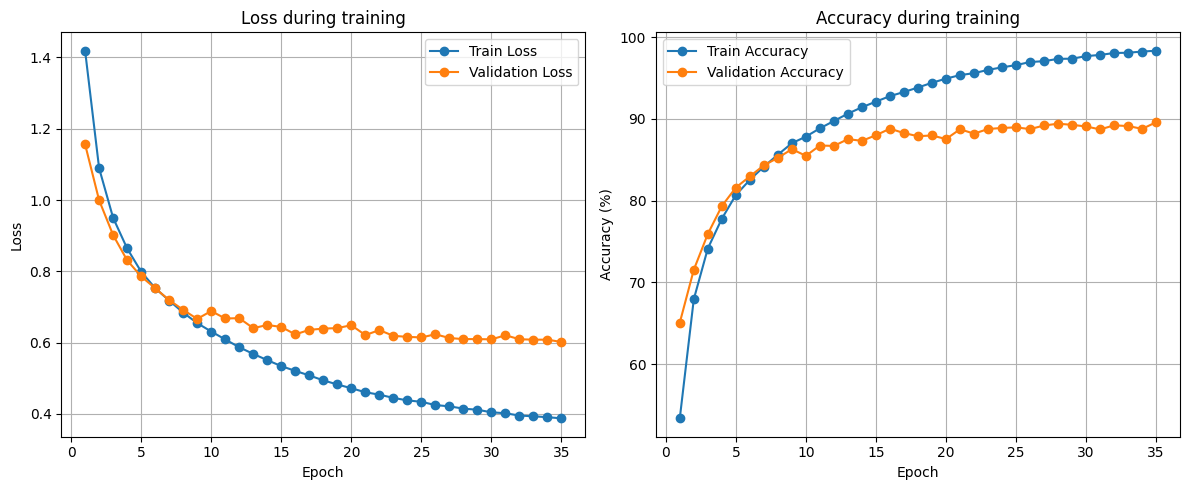

[TEST] loss: 0.6015 | acc: 89.60%

Classification report:
              precision    recall  f1-score   support

    airplane       0.90      0.91      0.90      1000
  automobile       0.93      0.95      0.94      1000
        bird       0.87      0.84      0.86      1000
         cat       0.84      0.76      0.80      1000
        deer       0.85      0.93      0.88      1000
         dog       0.85      0.84      0.85      1000
        frog       0.91      0.93      0.92      1000
       horse       0.91      0.94      0.92      1000
        ship       0.95      0.94      0.94      1000
       truck       0.95      0.92      0.94      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



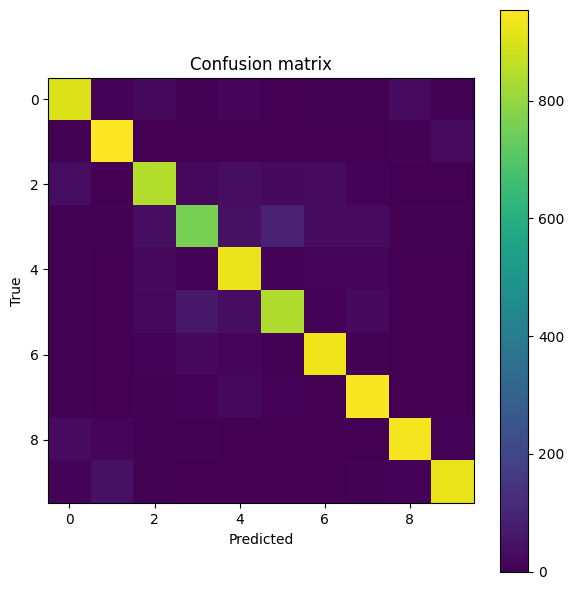

{'test_loss': 0.6014741830551587, 'test_acc': 89.6}


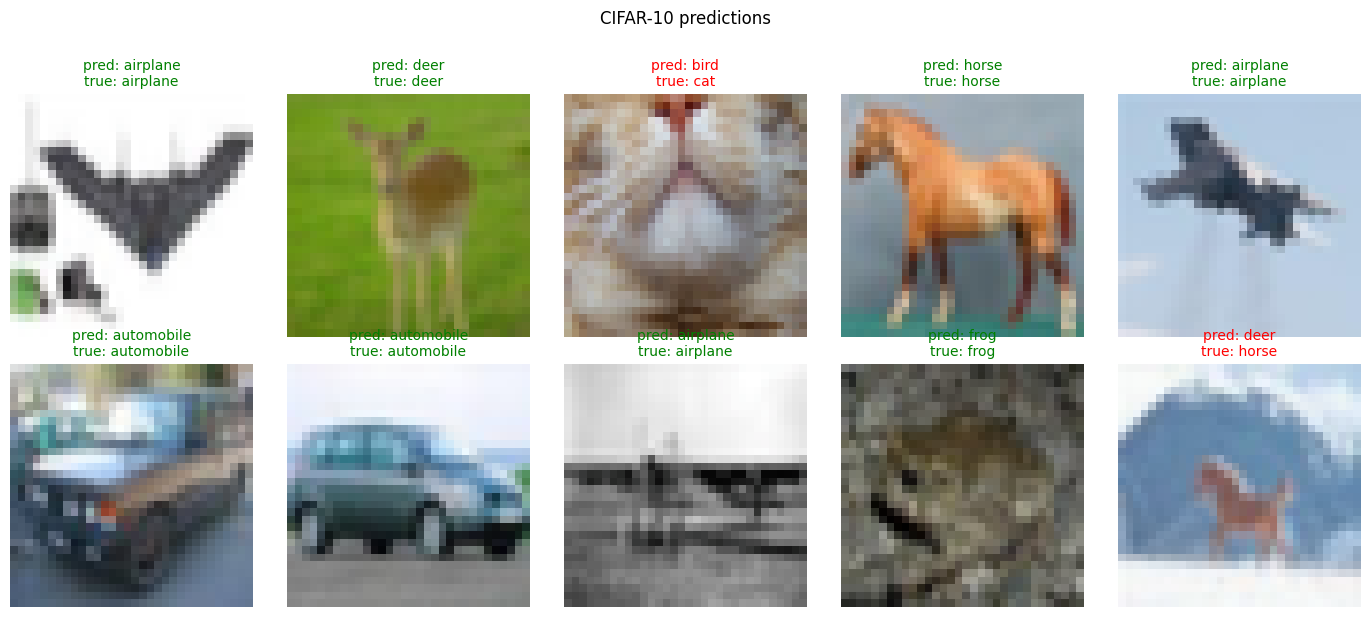

In [12]:
plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies)

# Затем — ваш существующий код:
metrics = evaluate_model(model, testLoader, criterion)
print(metrics)

show_predictions(
    model,
    testLoader,
    n=10,
    mean=(0.4914, 0.4822, 0.4465),
    std=(0.2470, 0.2435, 0.2616)
)

[TEST] loss: 0.6015 | acc: 89.60%

Classification report:
              precision    recall  f1-score   support

    airplane       0.90      0.91      0.90      1000
  automobile       0.93      0.95      0.94      1000
        bird       0.87      0.84      0.86      1000
         cat       0.84      0.76      0.80      1000
        deer       0.85      0.93      0.88      1000
         dog       0.85      0.84      0.85      1000
        frog       0.91      0.93      0.92      1000
       horse       0.91      0.94      0.92      1000
        ship       0.95      0.94      0.94      1000
       truck       0.95      0.92      0.94      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



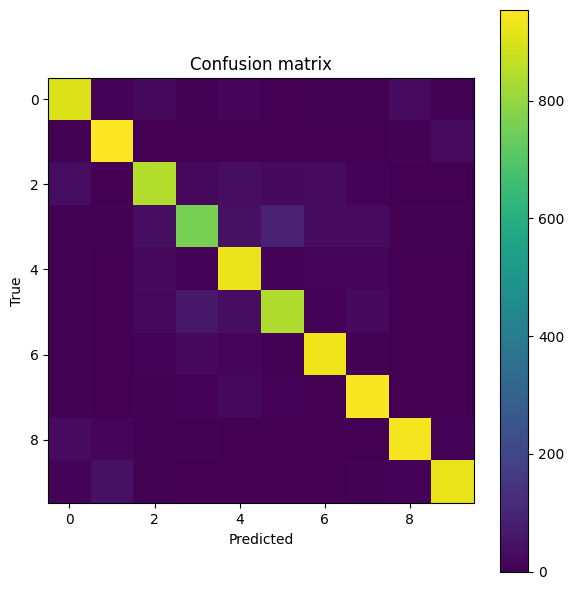

{'test_loss': 0.6014741830551587, 'test_acc': 89.6}


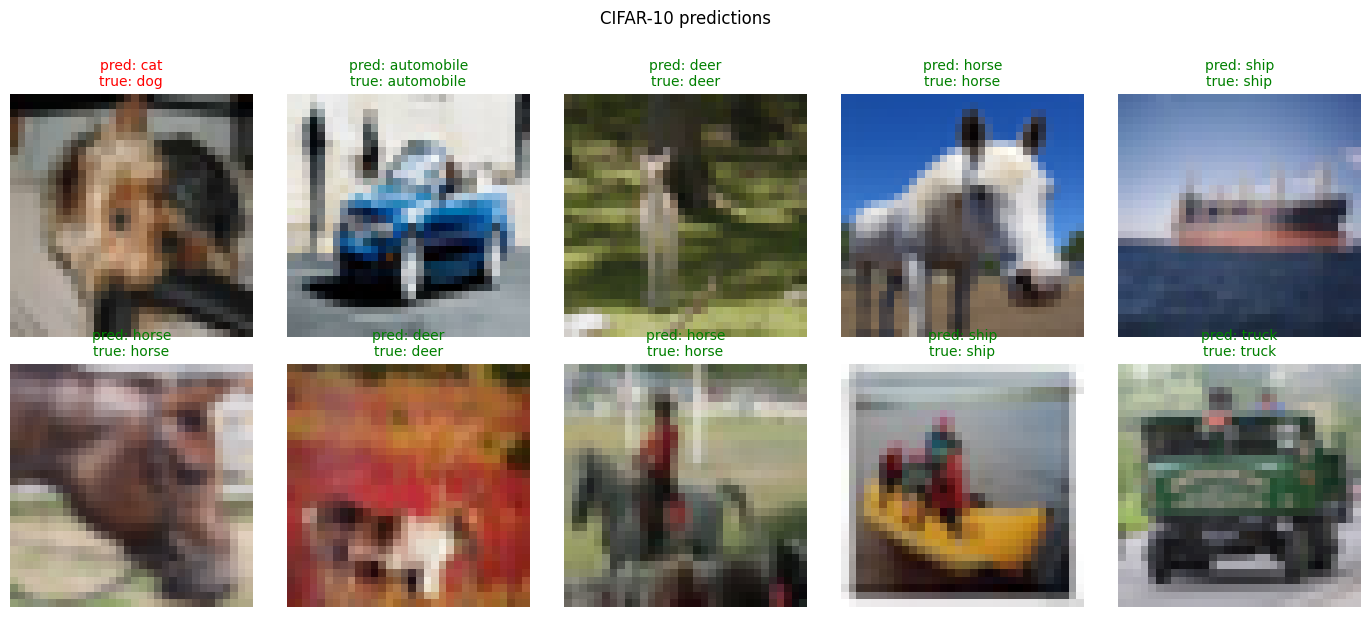

In [13]:

metrics = evaluate_model(model, testLoader, criterion)
print(metrics)

show_predictions(
    model,
    testLoader,
    n=10,
    mean=(0.4914, 0.4822, 0.4465),
    std=(0.2470, 0.2435, 0.2616)
)

